# FDA Adverse drug event reports

Multiple Sclerosis (MS) is a chronic disease that affects the central nervous system. Despite various treatments and drugs available to manage MS, the adverse effects of these drugs still pose a major challenge for patients. In this data science project, we aim to analyze the serious adverse effects of the top 5 Multiple Sclerosis drugs reported in the United States among patients aged 55 and above. Our objective is to identify which factors contribute to a patient experiencing serious adverse effects.

For this exercise we are going to code a prediction model for the serious adverse reactions of a set of drugs for patients > 55 years old and analyze the results of the model. We are focusing only on the data from one year (from 2021-11-04 to 2022-11-04).

### API requests

As the type of medication is not common, we need to divide the API calls to gather ~1000 useful entries.

First we will need to import all the libraries used in this exercise.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import requests

pd.set_option('display.max_columns', None)

We use the `requests` library to gather data from the FDA public API. In order to acquire as much useful data as possible we use the following parameters in the endpoint:

- First we indicate the rank of dates with `receivedate:[20211104+TO+20221104]`
- We select the sex of the patient, so in a first run of the 26 possible queries separated by 1000 retrieved data points we obtain the ones of female patients and in the second the male patients ( `patient.patientsex:2` and `patient.patientsex:1` respectively).
- We select the age of the target group with `patient.patientonsetage:[55+TO+90]`
- To avoid NaNs in the weight data, we also indicate the weight of the patient to be inside a wide range `patient.patientweight:[5+TO+200]`.

In [2]:
# Females
url = "https://api.fda.gov/drug/event.json?search=(receivedate:[20211104+TO+20221104])+AND+patient.patientsex:2+AND+patient.patientonsetage:[55+TO+90]+AND+patient.patientweight:[5+TO+200]&limit=1000"
req = requests.get(url)
data = req.json()["results"]
for i in range(1_000, 26_000, 1_000):
    url = f"https://api.fda.gov/drug/event.json?search=(receivedate:[20211104+TO+20221104])+AND+patient.patientsex:2+AND+patient.patientonsetage:[55+TO+90]+AND+patient.patientweight:[5+TO+200]&limit=1000&skip={i}"
    req = requests.get(url)
    data += req.json()["results"]

# Males
for i in range(0, 26_000, 1_000):
    url = f"https://api.fda.gov/drug/event.json?search=(receivedate:[20211104+TO+20221104])+AND+patient.patientsex:1+AND+patient.patientonsetage:[55+TO+90]+AND+patient.patientweight:[5+TO+200]&limit=1000&skip={i}"
    req = requests.get(url)
    data += req.json()["results"]


Now we convert the JSON of the requests to a pandas DataFrame to continue preparing the dataset.

In [3]:
df_all = pd.json_normalize(data)

In [4]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52000 entries, 0 to 51999
Data columns (total 41 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   safetyreportversion                       52000 non-null  object 
 1   safetyreportid                            52000 non-null  object 
 2   primarysourcecountry                      51789 non-null  object 
 3   transmissiondateformat                    52000 non-null  object 
 4   transmissiondate                          52000 non-null  object 
 5   reporttype                                51978 non-null  object 
 6   serious                                   52000 non-null  object 
 7   seriousnessdeath                          46197 non-null  object 
 8   seriousnesslifethreatening                46264 non-null  object 
 9   seriousnesshospitalization                48141 non-null  object 
 10  seriousnessdisabling              

### Feature engineering

The next step is to create/modify the columns of the dataframe to prepare the dataset.

First, we obtain columns with the number of adverse effects reported for each record and the number of different drugs the patient was taking.

In [5]:
df_all["n_react"] = df_all["patient.reaction"].apply(len)
df_all["n_drug"] = df_all["patient.drug"].apply(len)

There is information that is inside lists so we need to extract those columns to analyze the relation of the features with the outcome. This is done with the `explode` method.

In [6]:
df_all = df_all.explode('patient.reaction').reset_index(drop=True)
df_all = df_all.explode('patient.drug').reset_index(drop=True)
df_all = df_all.join(pd.json_normalize(df_all['patient.drug'].values)).drop('patient.drug', axis='columns')
df_all = df_all.join(pd.json_normalize(df_all['patient.reaction'])).drop('patient.reaction', axis='columns')

We are selecting only the drugs related to the illness that we care about in this exercise. So first, we fill all NaNs with "NA", and after that we create a boolean `sel` column to indicate which of the drug indications associated has "multiple sclerosis" in it.

Then we can just select the subsample related to the type of drugs we care about.

In [7]:
df_all["drugindication"] = df_all["drugindication"].fillna("NA")
df_all["sel"] =  df_all["drugindication"].apply(lambda x: "multiple sclerosis" in x.lower())
df_sel = df_all[df_all["sel"]].reset_index().drop(columns=["sel","index"])

Now, as the majority of the information is in the USA, in this exercise we focus only on patients in that country. We also filter the drugs that have the dosage in the same units, so they can be comparable.

In [8]:
df_sel = df_sel[df_sel["primarysource.reportercountry"] == "US"]
df_sel = df_sel[df_sel.drugstructuredosageunit == "003"]

Another selection that we specified in the project description, is that we are going to focus only on the 5 most reported MS drugs. So first we identify which of them are and then we filter the selection to those 5.

In [9]:
df_sel["openfda.brand_name"] = df_sel["openfda.brand_name"].fillna("NA")
df_sel["openfda.brand_name"] = df_sel["openfda.brand_name"].apply(lambda x: ",".join(x) if x != "NA" else "NA")
df_sel["openfda.brand_name"].value_counts()[:5]

OCREVUS                                787
AUBAGIO                                141
GLATIRAMER ACETATE,COPAXONE,GLATOPA     74
AUBAGIO,TERIFLUNOMIDE                   52
AMPYRA                                  49
Name: openfda.brand_name, dtype: int64

In [10]:
df_sel["sel"] = 0
for el in df_sel["openfda.brand_name"].value_counts()[:5].index:
    df_sel.loc[df_sel["openfda.brand_name"] == el, "sel"] = 1

df_sel = df_sel[df_sel["sel"] == 1].drop(columns=["sel"])

Related to the dosage of each selected drug, we convert the data to numeric and then only select the ones that have a valid value. 

In [11]:
df_sel["drugseparatedosagenumb"] = pd.to_numeric(df_sel["drugseparatedosagenumb"])
df_sel = df_sel[df_sel["drugseparatedosagenumb"] > 0]

Now we are going to replace the values in the columns`actiondrug` with more readable values and grouping some of them. It is coded from 1 to 6, meaning *Drug withdrawn*, *Dose reduced*, *Dose not changed*, *Dose increased*, *Unknown* and *Not applicable*, so we group the two initial ones.

In [12]:
df_sel = df_sel.replace({"actiondrug": {"1": "reduced","2": "reduced","3": "unchanged", 
                              "4": "increased", "5": "unknown","6": "na"}})

The following block of code will convert several columns to numeric to prevent them to be intepreted as categorical values.

In [13]:
df_sel["patient.patientweight"] = pd.to_numeric(df_sel["patient.patientweight"])
df_sel["patient.patientonsetage"] = pd.to_numeric(df_sel["patient.patientonsetage"])
df_sel["n_react"] = pd.to_numeric(df_sel["n_react"])
df_sel["n_drug"] = pd.to_numeric(df_sel["n_drug"])
df_sel["drugintervaldosageunitnumb"] = pd.to_numeric(df_sel["drugintervaldosageunitnumb"])

Lastly we are going to convert the outcome column `serious` to a numeric 1/0 column. According to de description of the values from the API, they mean:

- 1: The adverse event resulted in death, a life threatening condition, hospitalization, disability, congenital anomaly, or other serious condition.
- 2: The adverse event did not result in any of the above.

So we are going to change it to 1-> Serious adverse event and 0-> not result in a serious adverse event.

In [14]:
df_sel["serious"] = pd.to_numeric(df_sel["serious"].apply(lambda x: 1 if x == "1" else 0))

From all the possible features, we are going to select a set of features that are potentially of interest to explore its relation to the likelihood of a patient experiencing serious adverse effects. These are:

- `reactionoutcome`: If the patient is recovered or not. 
- `patient.patientweight`: Patient weight.
- `patient.patientonsetage`: Age of the patient.
- `patient.patientsex`: Male/Female.
- `drugseparatedosagenumb`: Amount of MS drug that the patient is consuming.
- `drugintervaldosageunitnumb`: Number of doses.
- `n_drug`: The number of drugs that the patient is taking, including the MS drug to be analyzed.
- `actiondrug`: Information about if the dosage has been changed or not.
- `openfda.brand_name`: Categorical feature with the name of the 5 different drugs we analyze in this exercise.
- `serious`: The outcome that we want to predict, if the adverse event resulted in any serious condition.

In [15]:
df_sel[["reactionoutcome","patient.patientweight","patient.patientonsetage","patient.patientsex",
        "drugseparatedosagenumb","drugintervaldosageunitnumb","n_drug",
       "actiondrug","openfda.brand_name","serious"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1003 entries, 8 to 3046
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   reactionoutcome             995 non-null    object 
 1   patient.patientweight       1003 non-null   float64
 2   patient.patientonsetage     1003 non-null   int64  
 3   patient.patientsex          1003 non-null   object 
 4   drugseparatedosagenumb      1003 non-null   float64
 5   drugintervaldosageunitnumb  1003 non-null   int64  
 6   n_drug                      1003 non-null   int64  
 7   actiondrug                  980 non-null    object 
 8   openfda.brand_name          1003 non-null   object 
 9   serious                     1003 non-null   int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 86.2+ KB


There are nor many NaNs so instead of trying to predict them, or assigning them to a category, we are going to drop them as they are only 23 data points.

In [16]:
df = df_sel[["reactionoutcome","patient.patientweight","patient.patientonsetage","patient.patientsex",
        "drugseparatedosagenumb","drugintervaldosageunitnumb","n_drug",
       "actiondrug","openfda.brand_name","serious"]].dropna()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 980 entries, 8 to 3046
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   reactionoutcome             980 non-null    object 
 1   patient.patientweight       980 non-null    float64
 2   patient.patientonsetage     980 non-null    int64  
 3   patient.patientsex          980 non-null    object 
 4   drugseparatedosagenumb      980 non-null    float64
 5   drugintervaldosageunitnumb  980 non-null    int64  
 6   n_drug                      980 non-null    int64  
 7   actiondrug                  980 non-null    object 
 8   openfda.brand_name          980 non-null    object 
 9   serious                     980 non-null    int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 84.2+ KB


In [18]:
df.sample(5)

,reactionoutcome,patient.patientweight,patient.patientonsetage,patient.patientsex,drugseparatedosagenumb,drugintervaldosageunitnumb,n_drug,actiondrug,openfda.brand_name,serious
2885,3,101.000,65,1,1.0,1,9,unknown,AUBAGIO,1
2290,6,77.180,73,1,1.0,15,5,unknown,OCREVUS,1
1379,3,97.156,56,2,1.0,6,12,unknown,OCREVUS,1
2791,1,89.438,58,1,1.0,6,12,unknown,OCREVUS,1
1237,6,90.800,55,2,1.0,6,2,na,OCREVUS,0


To visualize the distributions and proportions of the chosen features we are plotting bar plots and histograms, separating the contribution of the two different outcome clases. This is to check if we have data points across different categories and check if we need to ignore any feature o change anything.

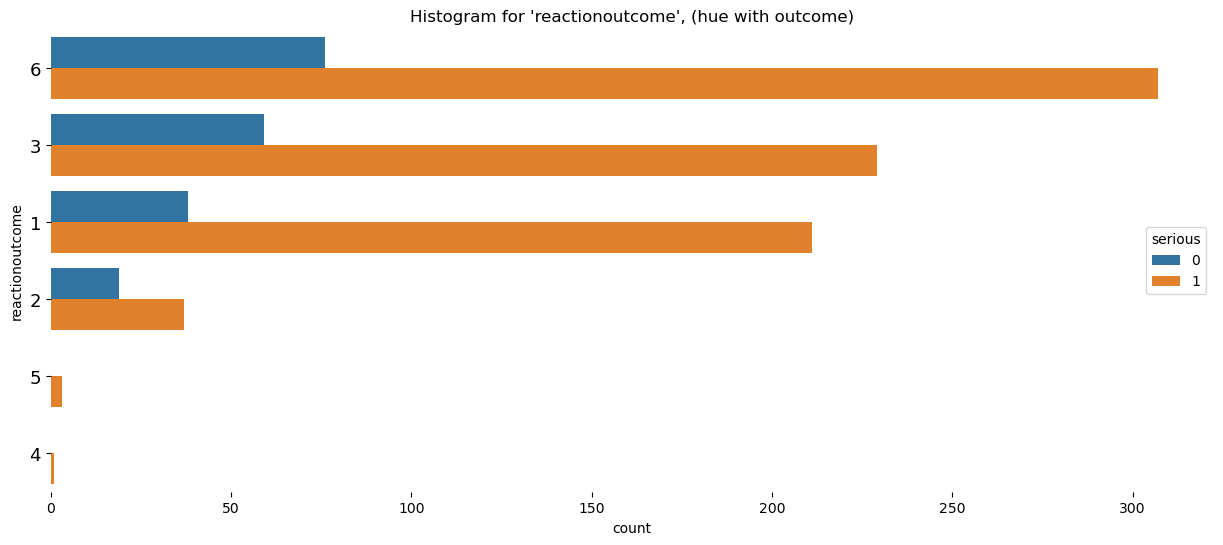

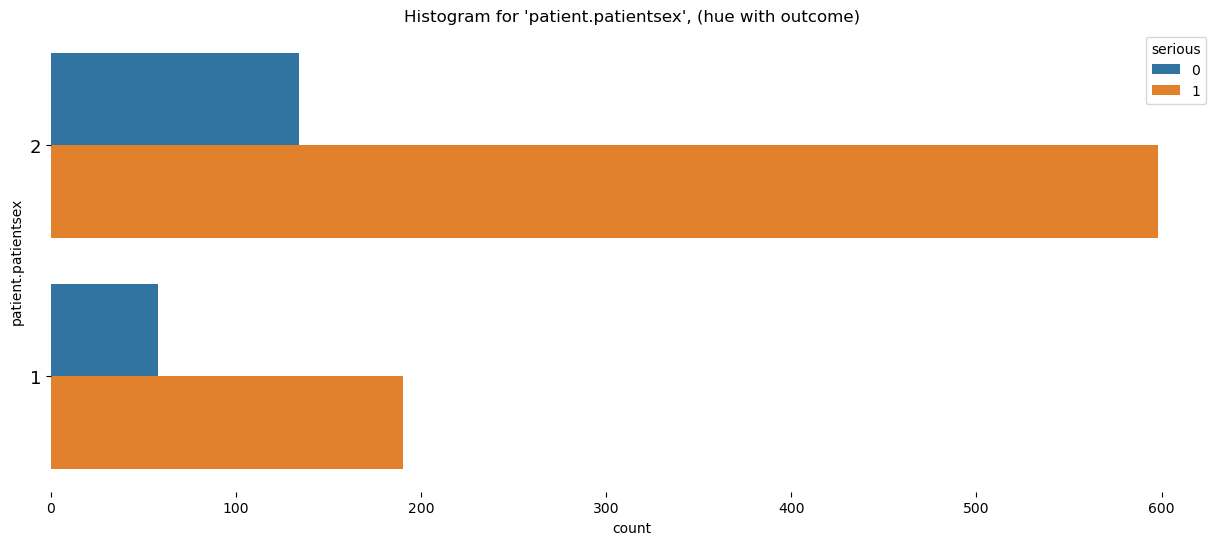

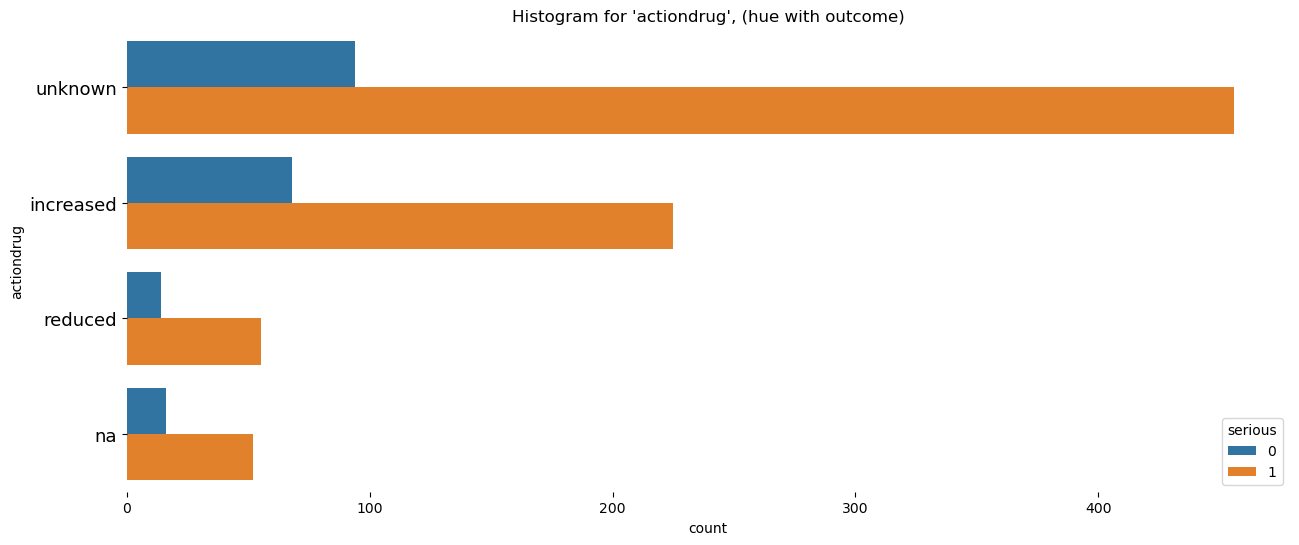

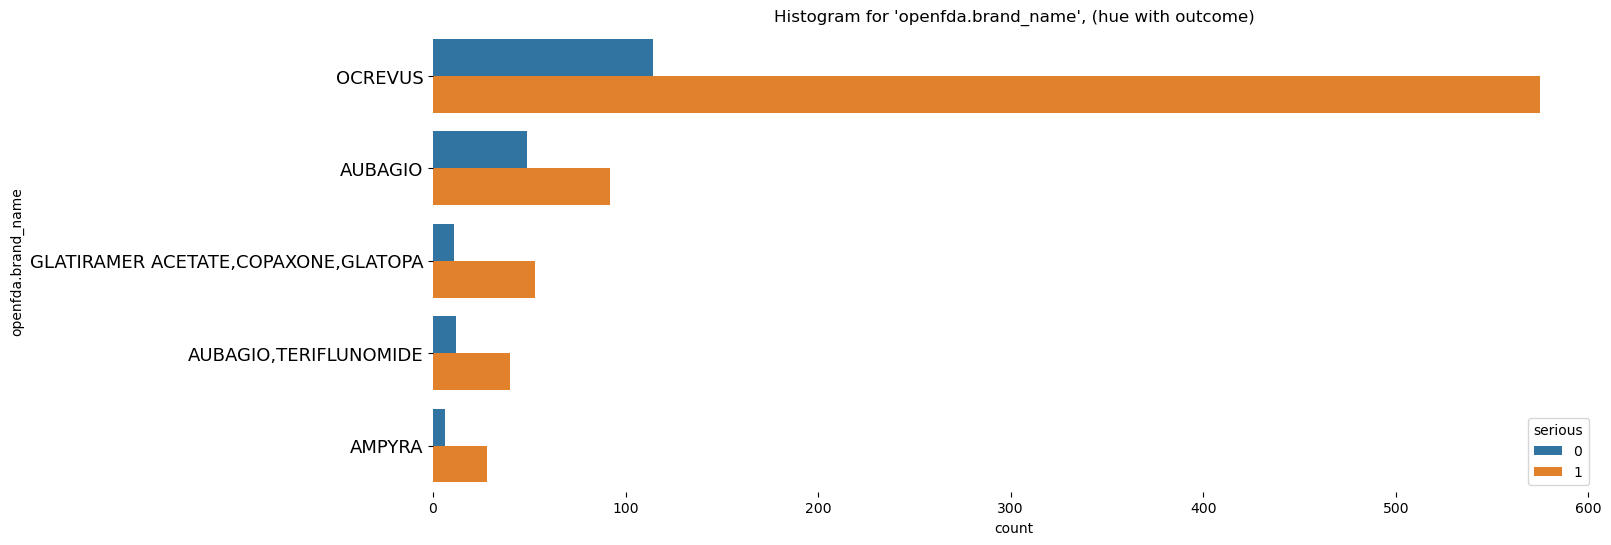

In [19]:
for i in df.select_dtypes(include=['object']).columns:
    fig, ax = plt.subplots(1,1, figsize=(15, 6))
    sns.countplot(y = df[i],data=df, order=df[i].value_counts().index, hue="serious")
    plt.title(f"Histogram for '{i}', (hue with outcome)")
    plt.yticks(fontsize=13)
    plt.box(False)
    plt.show()

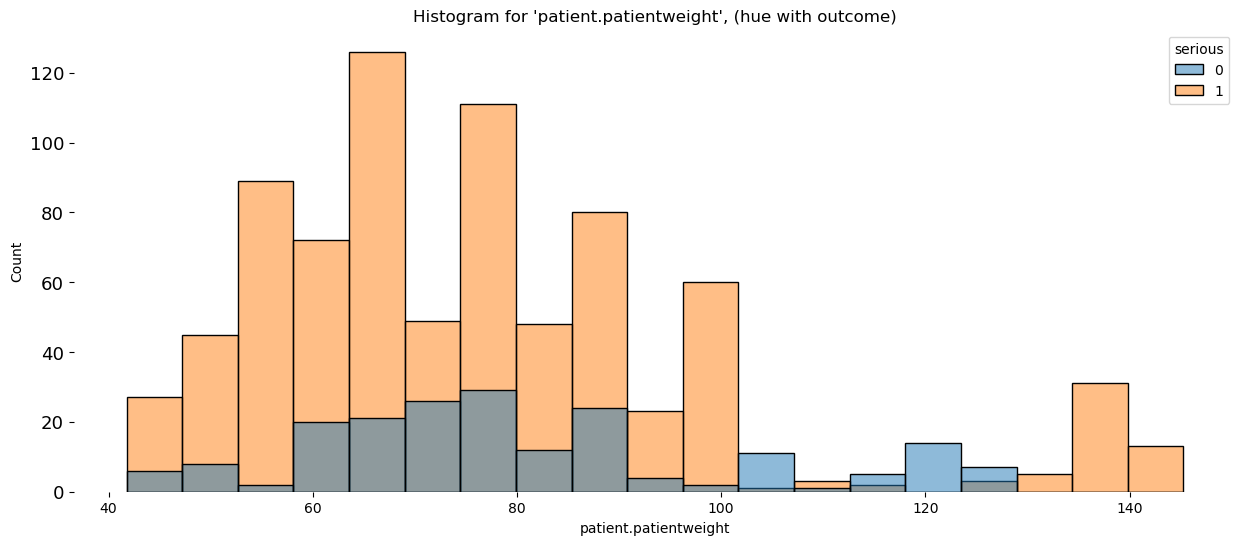

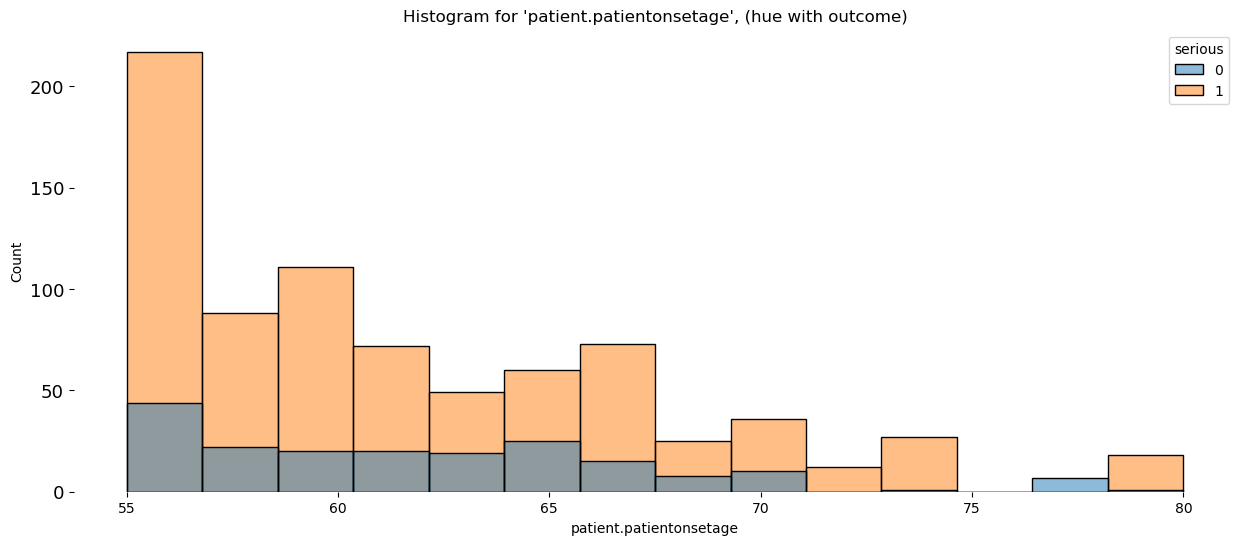

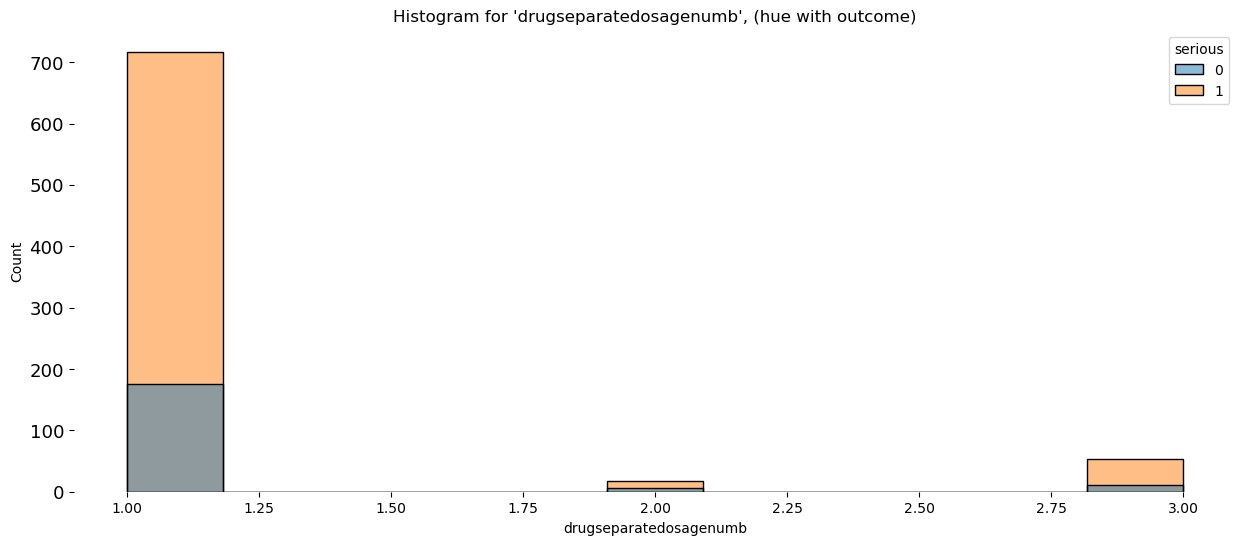

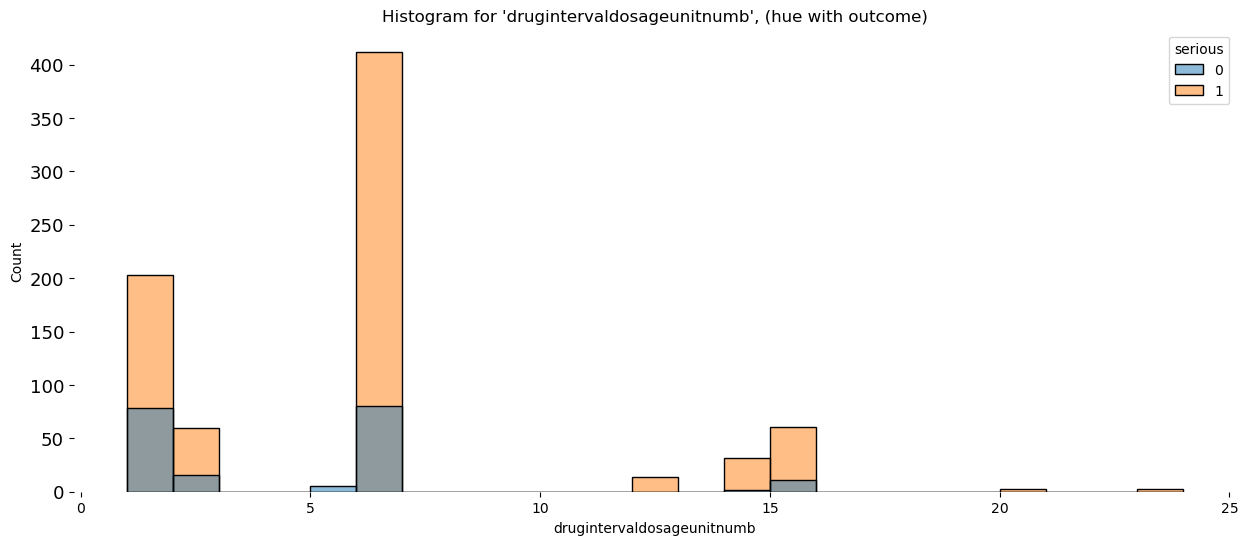

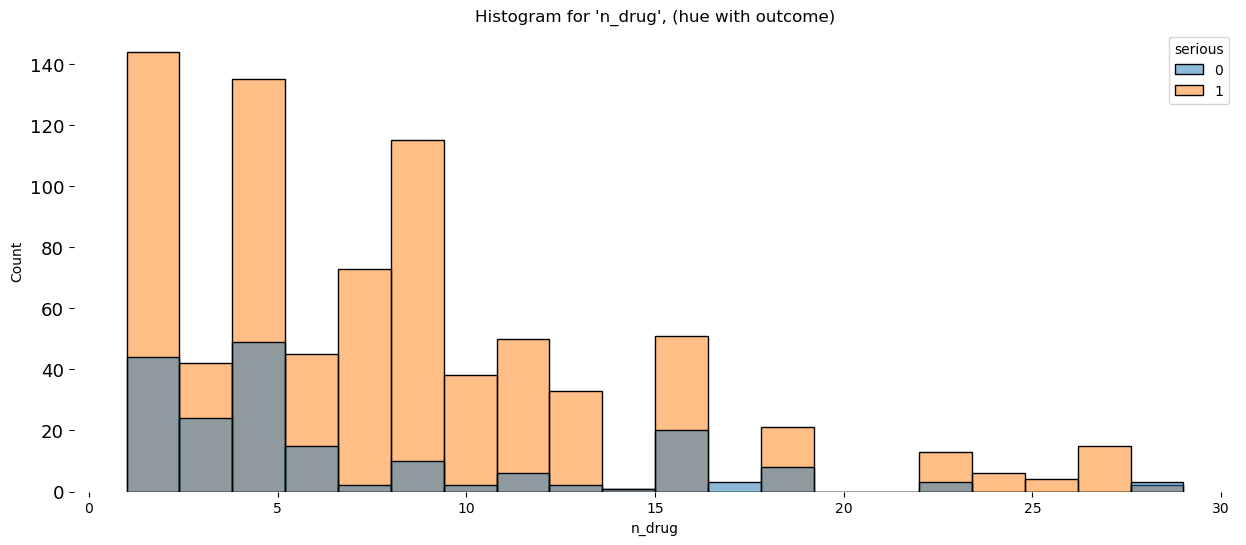

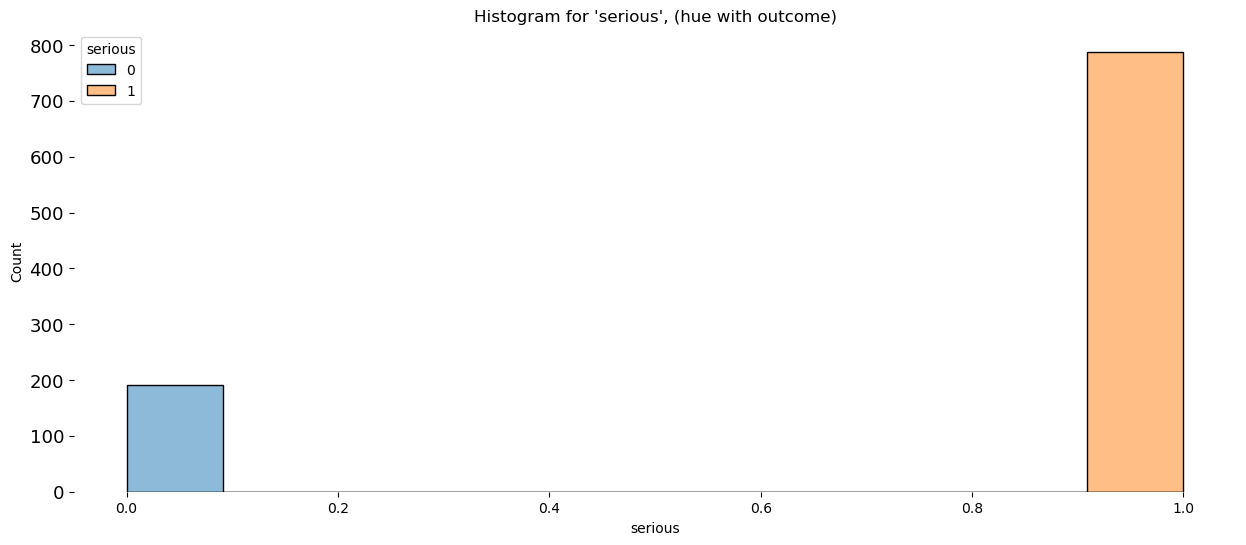

In [20]:
for i in df.select_dtypes(include=['int64','float64']).columns:
    fig, ax = plt.subplots(1,1, figsize=(15, 6))
    sns.histplot(data=df, x=i, hue="serious")
    plt.title(f"Histogram for '{i}', (hue with outcome)")
    plt.yticks(fontsize=13)
    plt.box(False)
    plt.show()

Lastly we are going to save the subsample that is going to be used in the next notebook to try to obtain the insights of which factors contribute to a patient experiencing serious adverse effects among the selected features.

In [21]:
df.to_csv("selection.csv", index=False)